# Demo Workflow & Decoupler
**Author:** [Severin Dicks](https://github.com/Intron7)

To run this notebook please make sure you have a working rapids enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import scanpy as sc
import anndata
import cupy as cp

import time
import rapids_singlecell as rsc

import warnings
warnings.filterwarnings("ignore")

In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [3]:
data_load_start = time.time()

In [4]:
%%time
adata = sc.read("h5/adata.raw.h5ad")

CPU times: user 2.35 s, sys: 480 ms, total: 2.83 s
Wall time: 2.87 s


In [5]:
%%time
rsc.utils.anndata_to_GPU(adata)

CPU times: user 1.52 s, sys: 1.04 s, total: 2.55 s
Wall time: 2.56 s


In [6]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 5.447770357131958


## Preprocessing

In [7]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [8]:
%%time
rsc.pp.flag_gene_family(adata,gene_family_name="MT", gene_family_prefix="MT")

CPU times: user 5.27 ms, sys: 1.21 ms, total: 6.48 ms
Wall time: 6.36 ms


In [9]:
%%time
rsc.pp.flag_gene_family(adata,gene_family_name="RIBO", gene_family_prefix="RPS")

CPU times: user 5.52 ms, sys: 0 ns, total: 5.52 ms
Wall time: 5.4 ms


In [10]:
%%time
rsc.pp.calculate_qc_metrics(adata,qc_vars=["MT","RIBO"])

CPU times: user 93.7 ms, sys: 4.33 ms, total: 98.1 ms
Wall time: 169 ms


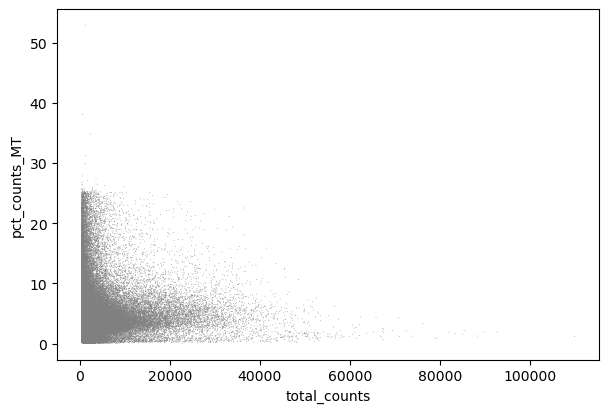

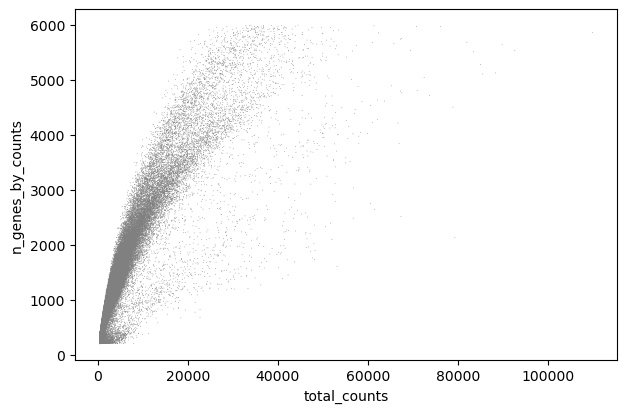

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

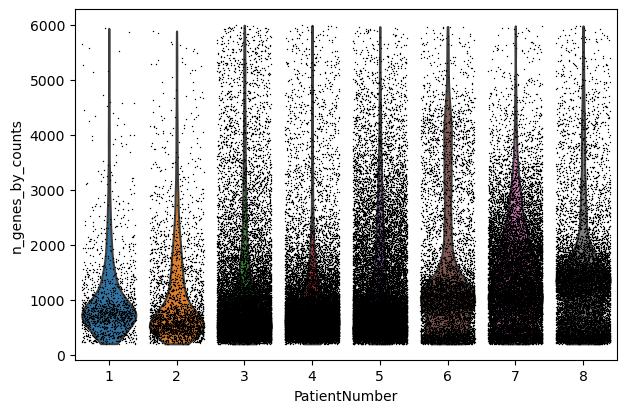

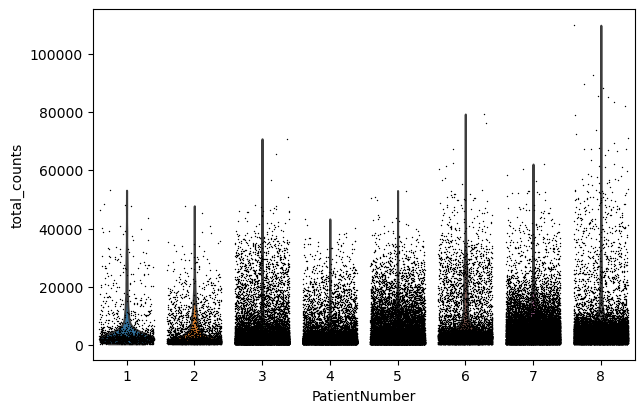

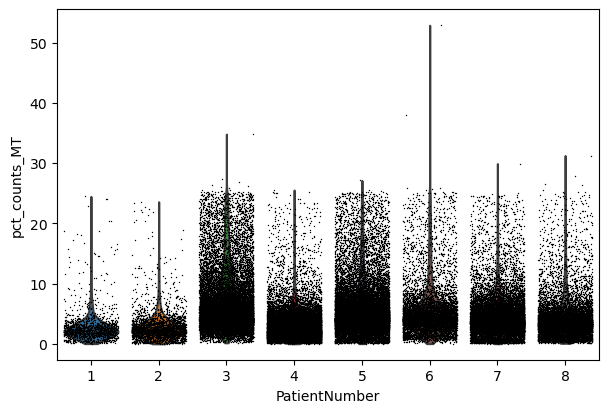

In [12]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, 'total_counts',jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, 'pct_counts_MT',jitter=0.4, groupby="PatientNumber")


### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [13]:
%%time
adata = adata[adata.obs["n_genes_by_counts"] < 5000]
adata = adata[adata.obs["pct_counts_MT"] < 20]

CPU times: user 23 ms, sys: 4.34 ms, total: 27.3 ms
Wall time: 26.6 ms


We also filter out genes that are expressed in less than 3 cells.

In [14]:
%%time
rsc.pp.filter_genes(adata,min_count=3)

filtered out 8034 genes based on n_cells_by_counts
CPU times: user 171 ms, sys: 68.9 ms, total: 240 ms
Wall time: 250 ms


The size of our count matrix is now reduced.

In [15]:
adata.shape

(91068, 25660)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [16]:
%%time
rsc.pp.normalize_total(adata,target_sum=1e4)

CPU times: user 822 µs, sys: 371 µs, total: 1.19 ms
Wall time: 7.45 ms


Next, we data transform the count matrix.

In [17]:
%%time
rsc.pp.log1p(adata)

CPU times: user 122 µs, sys: 3.42 ms, total: 3.55 ms
Wall time: 3.35 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `cell_ranger` for selecting highly variable genes based on the log normalized counts in `.X`

In [18]:
%%time
rsc.pp.highly_variable_genes(adata,n_top_genes=5000,flavor="cell_ranger")

CPU times: user 324 ms, sys: 45.2 ms, total: 370 ms
Wall time: 396 ms


Now we safe this verion of the AnnData as adata.raw. 

In [20]:
%%time
adata.raw = adata

CPU times: user 68.8 ms, sys: 65.7 ms, total: 135 ms
Wall time: 134 ms


Now we restrict our AnnData object to the highly variable genes.

In [22]:
%%time
rsc.pp.filter_highly_variable(adata)

CPU times: user 123 ms, sys: 134 ms, total: 257 ms
Wall time: 258 ms


Next we regess out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [23]:
%%time
rsc.pp.regress_out(adata,keys=["total_counts", "pct_counts_MT"])

CPU times: user 983 ms, sys: 916 ms, total: 1.9 s
Wall time: 2.18 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [24]:
%%time
rsc.pp.scale(adata,max_value=10)

CPU times: user 105 ms, sys: 3.57 ms, total: 108 ms
Wall time: 122 ms


Now we move `.X` out of the GPU.

In [25]:
%%time
rsc.utils.anndata_to_CPU(adata)

CPU times: user 148 ms, sys: 124 ms, total: 272 ms
Wall time: 272 ms


In [26]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 7.098259210586548


We have now finished the preprocessing of the data.

## Clustering and Visulization

### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from cuMLs.

In [27]:
%%time
rsc.tl.pca(adata, n_comps = 100)

CPU times: user 1.61 s, sys: 728 ms, total: 2.34 s
Wall time: 2.35 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

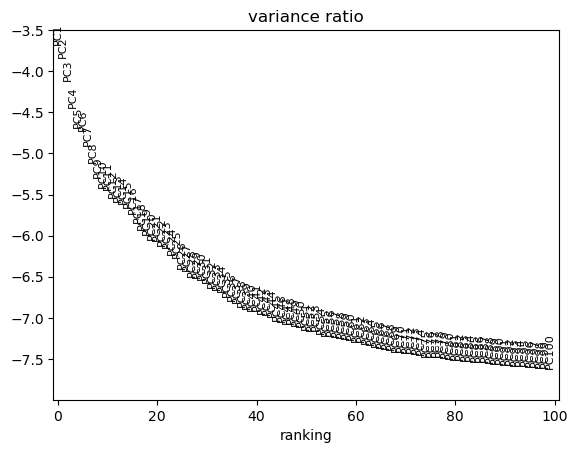

In [28]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using rsc.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the excat graph. Both methods are valid, but you might see differences.

In [29]:
%%time
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

CPU times: user 256 ms, sys: 28.5 ms, total: 284 ms
Wall time: 298 ms


Next we calculate the UMAP embedding using rapdis.

In [30]:
%%time
rsc.tl.umap(adata)

CPU times: user 392 ms, sys: 16.6 ms, total: 408 ms
Wall time: 407 ms


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.

In [31]:
%%time
rsc.tl.louvain(adata, resolution=0.6)

CPU times: user 311 ms, sys: 482 ms, total: 793 ms
Wall time: 793 ms


In [32]:
%%time
rsc.tl.leiden(adata,resolution=0.6)

CPU times: user 297 ms, sys: 468 ms, total: 765 ms
Wall time: 766 ms


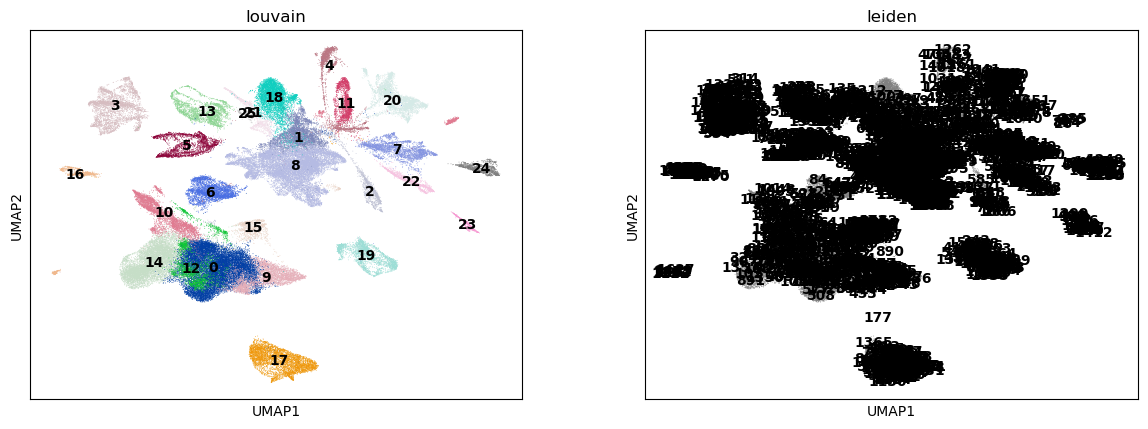

CPU times: user 1.98 s, sys: 171 ms, total: 2.15 s
Wall time: 1.97 s


In [33]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

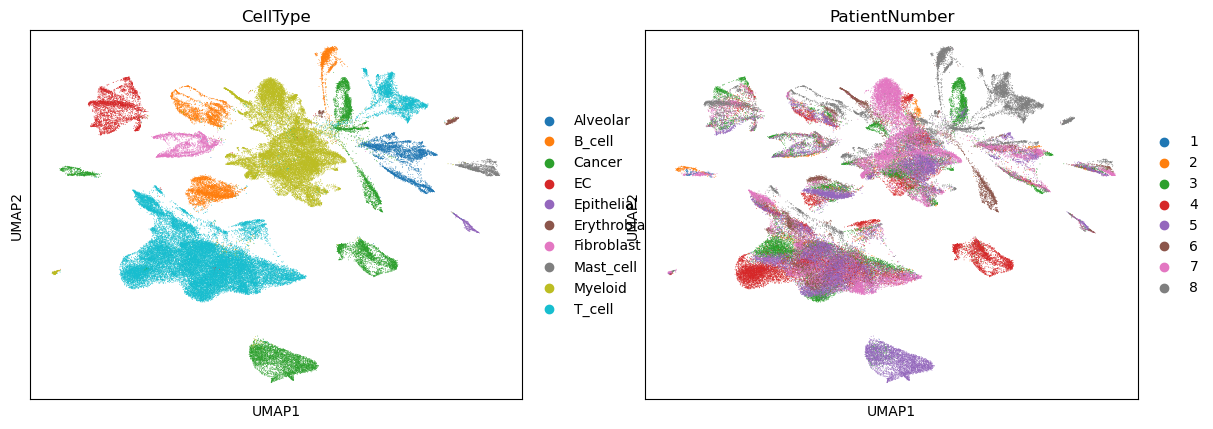

In [34]:
sc.pl.umap(adata, color= ["CellType", "PatientNumber"])

### TSNE + k-Means

Next we use TSNE on the GPU to visualize the cells in two dimensions. We also perform k-Means clustering of the cells into 8 clusters.

In [35]:
%%time
rsc.tl.tsne(adata, n_pcs = 40,perplexity=30,early_exaggeration=12, learning_rate=200)

[W] [15:50:32.565011] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 1.24 s, sys: 1.41 s, total: 2.65 s
Wall time: 2.65 s


In [36]:
rsc.tl.kmeans(adata, n_clusters=8)

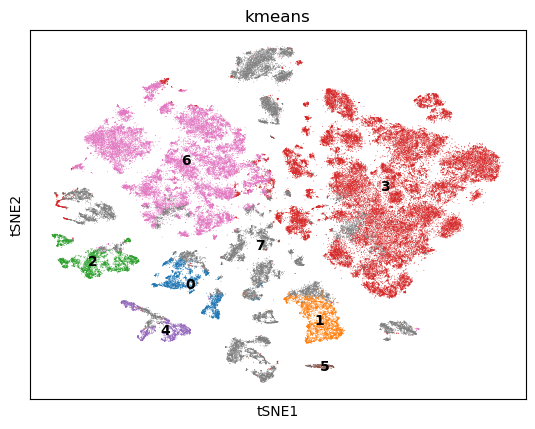

CPU times: user 325 ms, sys: 163 ms, total: 488 ms
Wall time: 306 ms


In [37]:
%%time
sc.pl.tsne(adata, color=["kmeans"],legend_loc = 'on data')

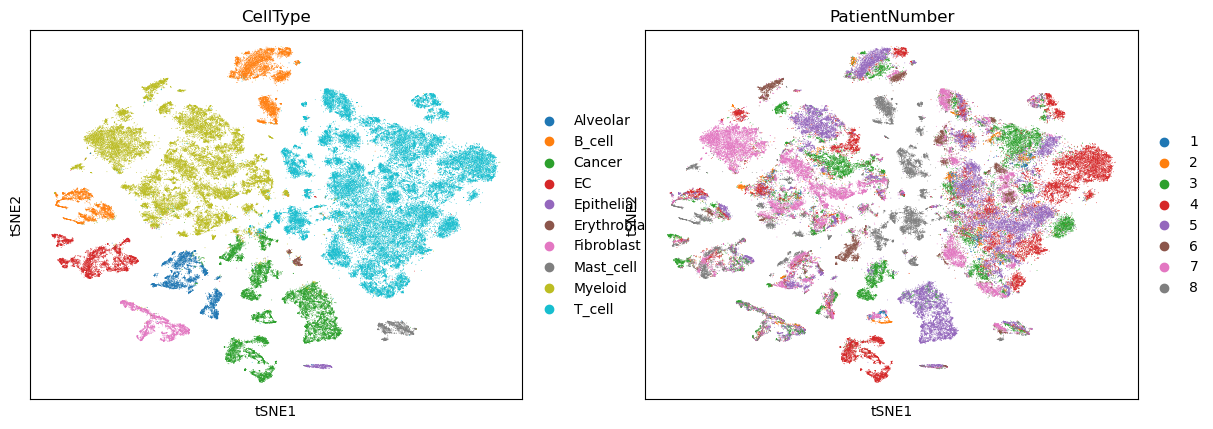

In [38]:
sc.pl.tsne(adata, color= ["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [39]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="CellType", use_raw=False)

CPU times: user 2.35 s, sys: 673 ms, total: 3.02 s
Wall time: 3.05 s


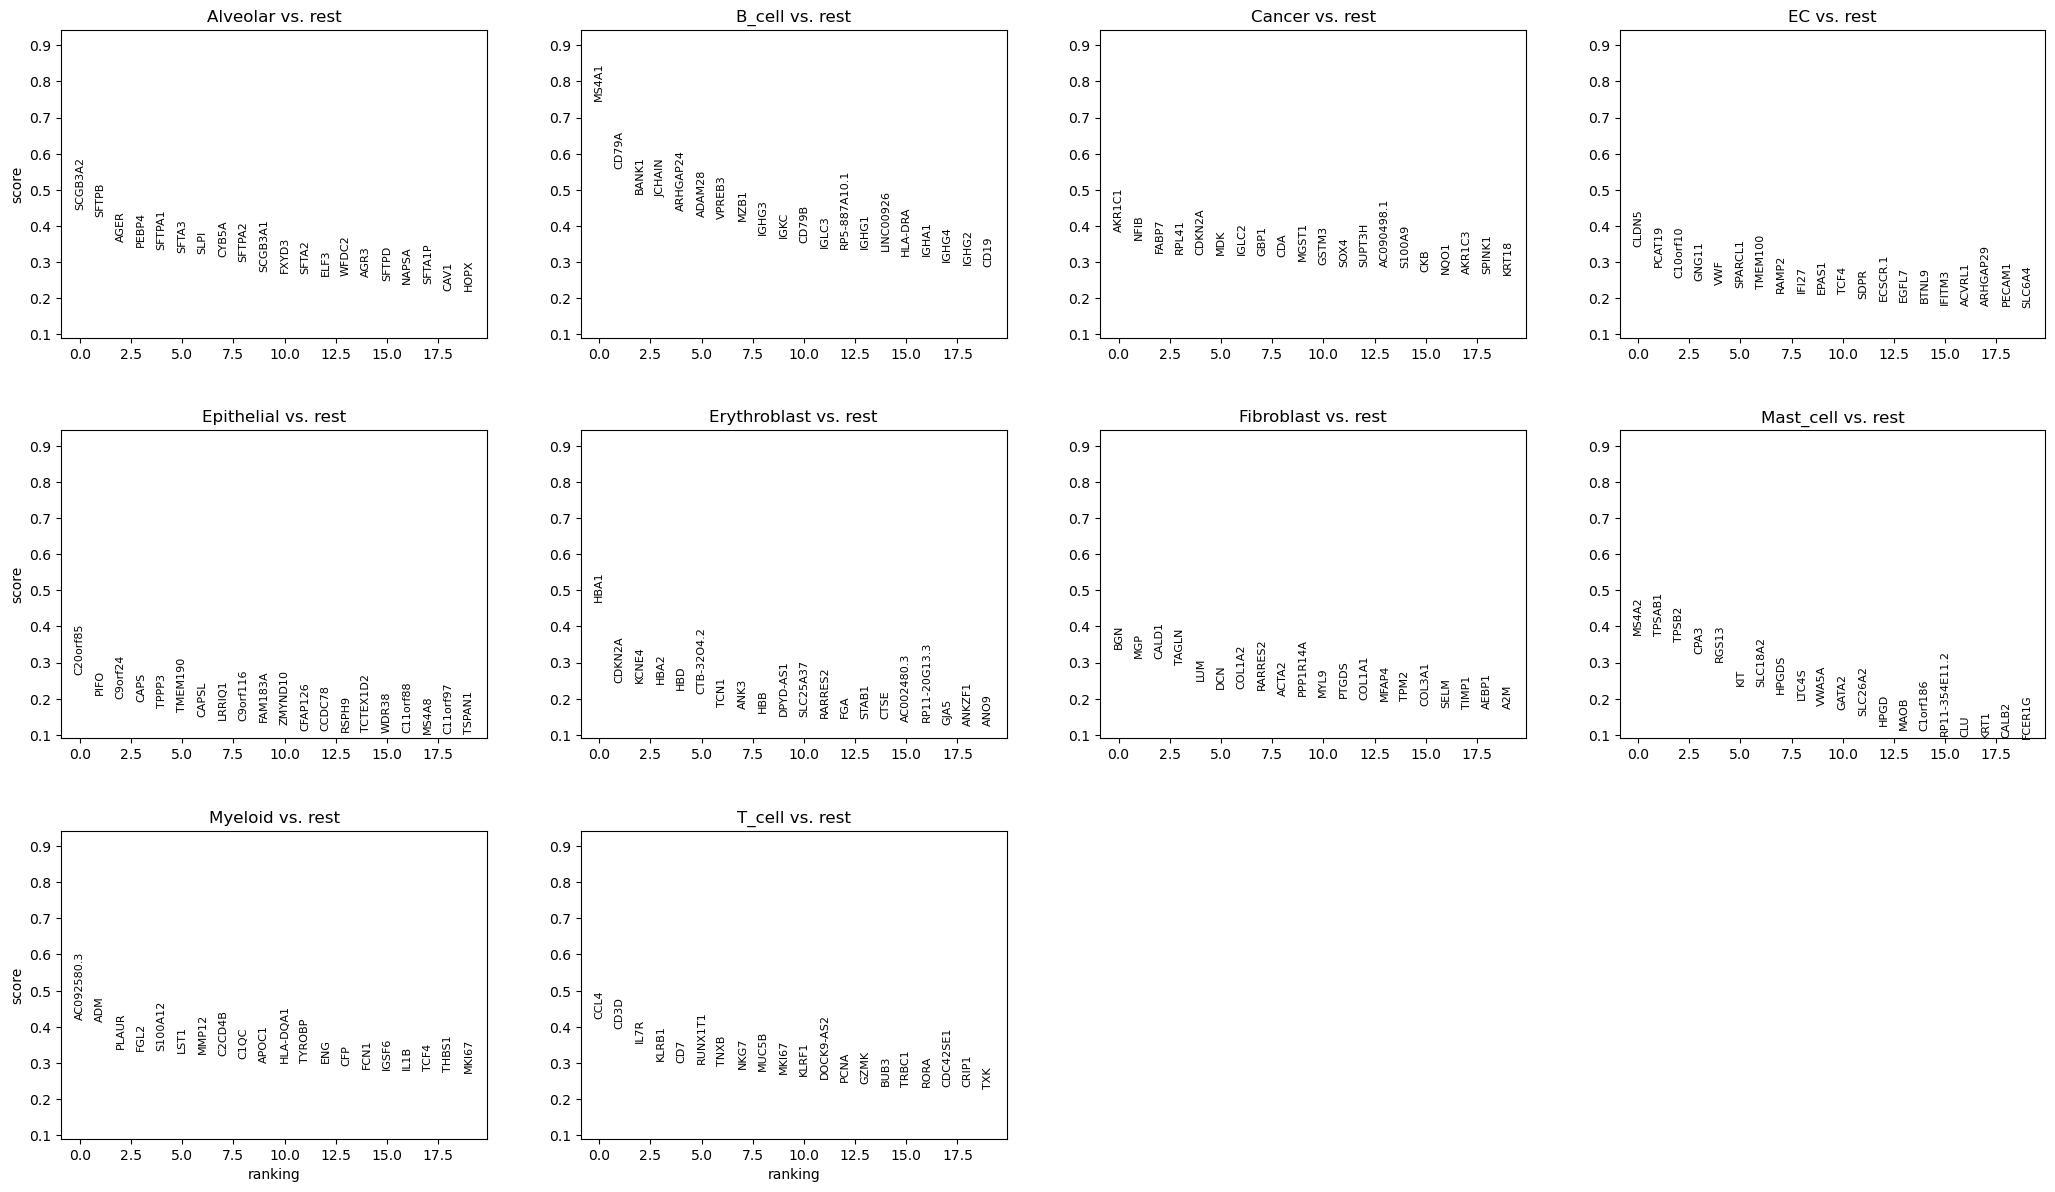

In [40]:
sc.pl.rank_genes_groups(adata)

In [41]:
post_time = time.time()

In [42]:
print("Total Postprocessing time: %s" % (post_time-preprocess_time))

Total Postprocessing time: 15.594274759292603


## Diffusion Maps

With cupy 9 its possible to compute Eigenvalues of sparse matrixes. We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [43]:
tdata = adata[adata.obs["CellType"] == 'T_cell',:].copy()

We can repeat the dimension reduction, clustering and visulatization.

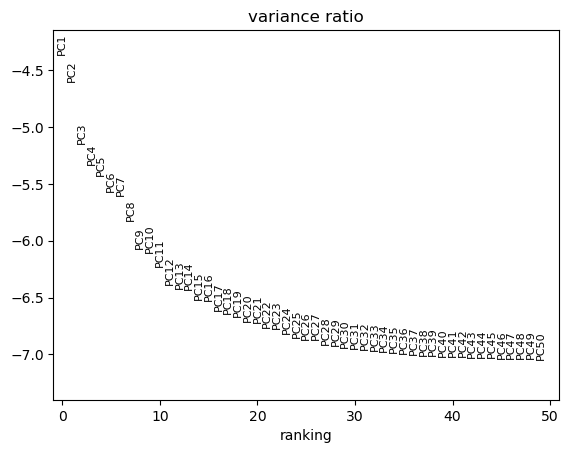

CPU times: user 930 ms, sys: 561 ms, total: 1.49 s
Wall time: 1.31 s


In [44]:
%%time
rsc.pp.pca(tdata,n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True,n_pcs=50)

In [45]:
%%time
rsc.pp.neighbors(tdata, n_neighbors=15, n_pcs=20)
rsc.tl.umap(tdata)
rsc.tl.louvain(tdata)

CPU times: user 322 ms, sys: 191 ms, total: 514 ms
Wall time: 514 ms


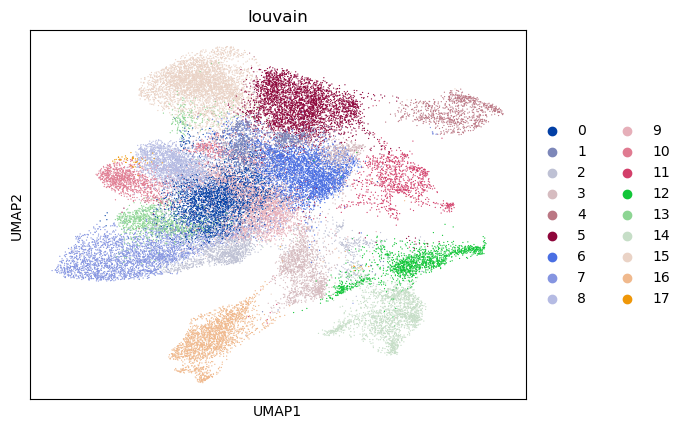

In [46]:
sc.pl.umap(tdata, color=["louvain"])

As stated before Diffusion Maps have become an integral part of single cell analysis. To run the computation with cupy 9, you can use `scanpy_gpu_funcs` implementation.

In [47]:
%%time
rsc.tl.diffmap(tdata)

CPU times: user 374 ms, sys: 1.33 s, total: 1.7 s
Wall time: 190 ms


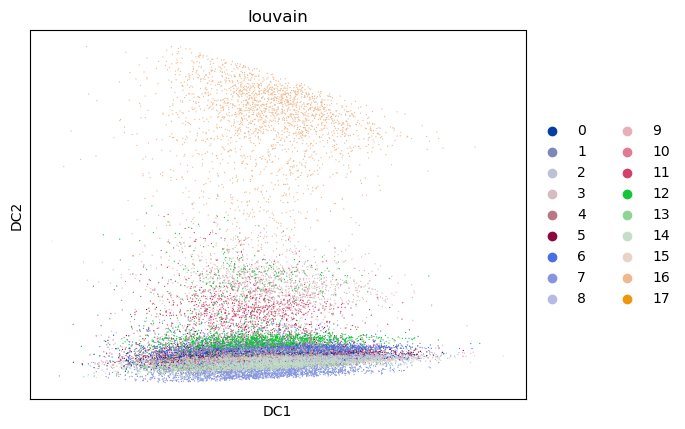

In [48]:
sc.pl.diffmap(tdata, color='louvain')

In [49]:
%%time
rsc.tl.draw_graph(tdata)

CPU times: user 336 ms, sys: 12.5 ms, total: 349 ms
Wall time: 348 ms


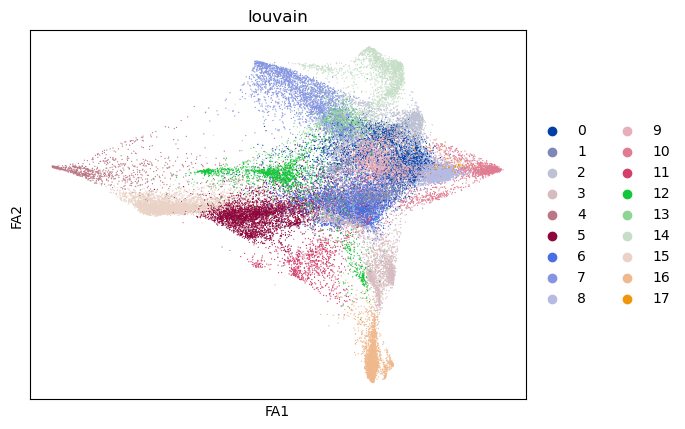

In [50]:
sc.pl.draw_graph(tdata, color='louvain')

After this you can use `X_diffmap` for `sc.pp.neighbors` and other fuctions. 

In [51]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 26.433725118637085


## Decoupler-GPU

Here I introduce 2 functions of the `decoupler` package that have been accelerated with cupy: `mlm`and `wsum`.
You can use the same `nets` that you would use with the CPU implementation.

In [52]:
import decoupler as dc

In [53]:
net = dc.get_dorothea(organism='human', levels=['A','B','C'])

In [54]:
adata.raw.X.shape

(91068, 25660)

In [55]:
%%time
rsc.dcg.run_mlm(mat=adata, net=net, source='source', target='target', weight='weight', verbose=True)

4 features of mat are empty, they will be removed.
Running mlm on mat with 91068 samples and 25656 targets for 297 sources.


100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


CPU times: user 8.42 s, sys: 3.89 s, total: 12.3 s
Wall time: 12.4 s


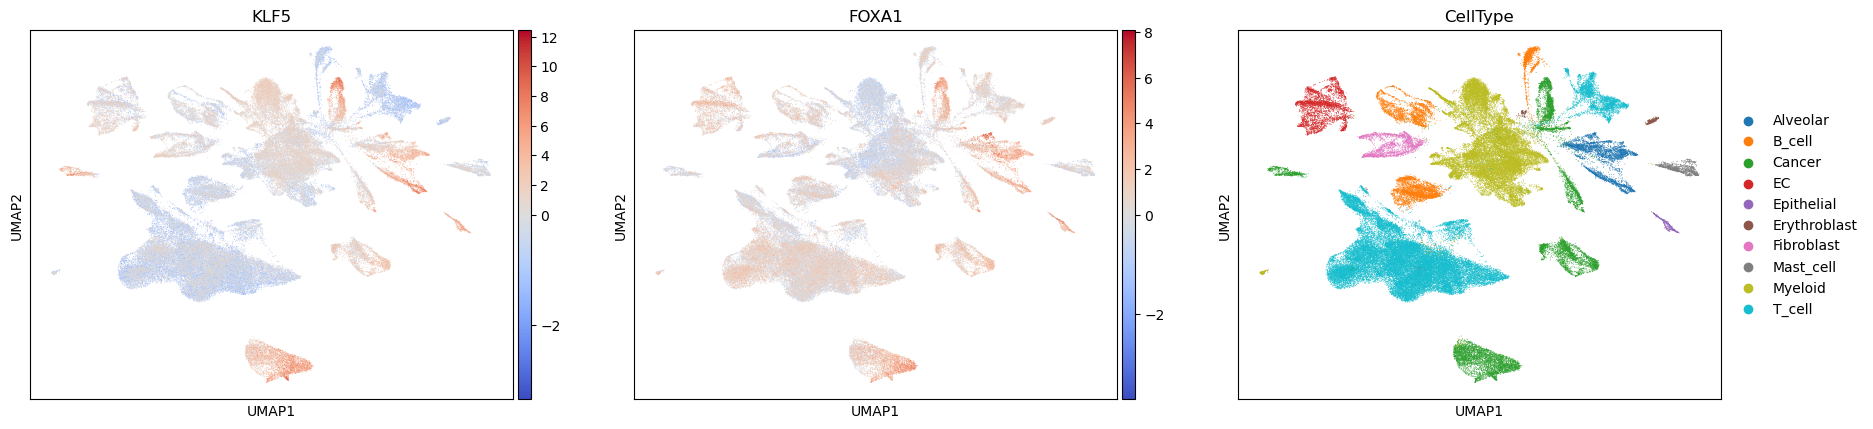

In [56]:
acts_mlm = dc.get_acts(adata, obsm_key='mlm_estimate')
sc.pl.umap(acts_mlm, color=['KLF5',"FOXA1", 'CellType'], cmap='coolwarm', vcenter=0)

In [57]:
model = dc.get_progeny(organism='human', top=100)

In [58]:
%%time
rsc.dcg.run_wsum(mat=adata, net=model, source='source', target='target', weight='weight', verbose=True)

4 features of mat are empty, they will be removed.
Running wsum on mat with 91068 samples and 25656 targets for 14 sources.
Infering activities on 10 batches.


100%|██████████| 10/10 [00:26<00:00,  2.65s/it]

CPU times: user 50.6 s, sys: 59.9 s, total: 1min 50s
Wall time: 28.2 s
